# Saving Flow Analysis Data as AnnData objects for ScanPy

## Create AnnData object from FlowJo Workspace analysis

In [1]:
import os
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import joypy
import flowkit as fk

In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)
# warnings.simplefilter('ignore', RuntimeWarning)
# warnings.simplefilter('ignore', FutureWarning)
# warnings.simplefilter('ignore', pd.errors.PerformanceWarning)

In [3]:
# sc.settings.verbosity = 3
# sc.settings.set_figure_params(dpi=75, facecolor='white')
# sc.logging.print_header()

In [4]:
base_dir = "../../../data/8_color_data_set"
sample_path = os.path.join(base_dir, "fcs_files")
wsp_path = os.path.join(base_dir, "8_color_ICS.wsp")

seed = 123

### Import FlowJo workspace and process samples

In [5]:
workspace = fk.Workspace(wsp_path, fcs_samples=sample_path)

In [6]:
workspace.summary()

samples  loaded_samples  gates  max_gate_depth
group_name                                                 
All Samples        3               3     14               6
DEN                3               3     14               6
GEN                0               0      0               0
G69                0               0      0               0
Lyo Cells          0               0      0               0

In [7]:
# The 'DEN' group has the analysis of interest
sample_group = 'DEN'
sample_ids = workspace.get_sample_ids(group_name=sample_group)

In [8]:
# check the event counts for all samples (just for sanity checking our data)
for sample_id in sample_ids:
    sample = workspace.get_sample(sample_id)
    print(sample_id, sample.event_count)

101_DEN084Y5_15_E01_008_clean.fcs 290172
101_DEN084Y5_15_E03_009_clean.fcs 283969
101_DEN084Y5_15_E05_010_clean.fcs 285290


In [9]:
workspace.analyze_samples(sample_group)

### Get Boolean arrays of gate membership for all events for all gates for each sample

In [10]:
# DataFrame to hold gate membership data, columns are gates, rows are events
df_gate_membership = pd.DataFrame()

# choose a sample to get the gates from, we assume all samples have the same gate tree
for gate_name, gate_path in workspace.get_gate_ids(sample_ids[0]):
    results = []
    for sample_id in sample_ids:
        result = workspace.get_gate_membership(
            sample_id, 
            gate_name=gate_name, 
            gate_path=gate_path
        )
        results.append(result)
    
    results = np.concatenate(results)
    df_gate_membership[':'.join(list(gate_path) + [gate_name])] = results

In [11]:
df_gate_membership.head()

root:Time  root:Time:Singlets  root:Time:Singlets:aAmine-  \
0      False               False                       False   
1      False               False                       False   
2      False               False                       False   
3      False               False                       False   
4      False               False                       False   

   root:Time:Singlets:aAmine-:CD3+  root:Time:Singlets:aAmine-:CD3+:CD4+  \
0                            False                                 False   
1                            False                                 False   
2                            False                                 False   
3                            False                                 False   
4                            False                                 False   

   root:Time:Singlets:aAmine-:CD3+:CD4+:CD107a+  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4                                         False   

   root:Time:Singlets:aAmine-:CD3+:CD4+:IFNg+  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   root:Time:Singlets:aAmine-:CD3+:CD4+:IL2+  \
0                                      False   
1                                      False   
2                                      False   
3                                      False   
4                                      False   

   root:Time:Singlets:aAmine-:CD3+:CD4+:TNFa+  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   root:Time:Singlets:aAmine-:CD3+:CD8+  \
0                                 False   
1                                 False   
2                                 False   
3                                 False   
4                                 False   

   root:Time:Singlets:aAmine-:CD3+:CD8+:CD107a+  \
0                                         False   
1                                         False   
2                                         False   
3                                         False   
4                                         False   

   root:Time:Singlets:aAmine-:CD3+:CD8+:IFNg+  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   root:Time:Singlets:aAmine-:CD3+:CD8+:IL2+  \
0                                      False   
1                                      False   
2                                      False   
3                                      False   
4                                      False   

   root:Time:Singlets:aAmine-:CD3+:CD8+:TNFa+  
0                                       False  
1                                       False  
2                                       False  
3                                       False  
4                                       False

In [12]:
# verify our event count looks right
df_gate_membership.shape

(859431, 14)

### Get processed events for all samples

A FlowJo workspace has a set of transforms, one for each channel in a sample. However, all samples are not guaranteed to have the same set of transforms, so always good to check them.

We'll use the `get_gate_events` method without specifying the gate to get processed events for the root level (i.e. all events for each sample).

In [13]:
df_processed_events = []

for sample_id in sample_ids:
    # The get_gate_events method returns all events if not given a gate
    df = workspace.get_gate_events(sample_id)
    df_processed_events.append(df)

df_processed_events = pd.concat(df_processed_events)

In [14]:
df_processed_events.shape

(859431, 16)

In [15]:
df_processed_events.head()

sample_id     FSC-A     FSC-H     FSC-W     SSC-A  \
0  101_DEN084Y5_15_E01_008_clean.fcs  0.669193  0.550243  0.304044  0.145722   
1  101_DEN084Y5_15_E01_008_clean.fcs  0.470615  0.405136  0.290405  0.200456   
2  101_DEN084Y5_15_E01_008_clean.fcs  0.618339  0.518814  0.297958  0.165320   
3  101_DEN084Y5_15_E01_008_clean.fcs  0.466790  0.384033  0.303874  0.136375   
4  101_DEN084Y5_15_E01_008_clean.fcs  0.321537  0.268814  0.299033  0.119671   

      SSC-H     SSC-W  TNFa FITC FLR-A  CD8 PerCP-Cy55 FLR-A  IL2 BV421 FLR-A  \
0  0.136929  0.266054         0.246065              0.297479         0.280577   
1  0.187286  0.267580         0.243213              0.402105         0.281486   
2  0.157120  0.263048         0.236940              0.638401         0.275555   
3  0.127686  0.267014         0.241100              0.646098         0.272339   
4  0.111221  0.268994         0.248873              0.478198         0.328231   

   Aqua Amine FLR-A  IFNg APC FLR-A  CD3 APC-H7 FLR-A  CD107a PE FLR-A  \
0          0.248555        0.255891          0.532903         0.300733   
1          0.245255        0.249686          0.212227         0.278771   
2          0.247613        0.247531          0.466408         0.281839   
3          0.249497        0.249413          0.433891         0.275977   
4          0.258179        0.231071          0.487078         0.328163   

   CD4 PE-Cy7 FLR-A      Time  
0          0.566413  0.035940  
1          0.244356  0.035983  
2          0.268400  0.036026  
3          0.238305  0.036040  
4          0.288373  0.036068

### Create AnnData object

The initial data will be the processed events

In [16]:
# event values without the sample_id column
data = df_processed_events.iloc[:, 1:].values

In [17]:
adata = ad.AnnData(data, dtype=data.dtype)

In [18]:
adata.X

array([[0.66919339, 0.55024338, 0.30404428, ..., 0.30073305, 0.56641316,
        0.03594016],
       [0.47061452, 0.40513611, 0.29040521, ..., 0.27877141, 0.24435586,
        0.03598285],
       [0.6183387 , 0.51881409, 0.29795775, ..., 0.28183939, 0.26840002,
        0.03602554],
       ...,
       [0.49872547, 0.42063522, 0.29641208, ..., 0.27990703, 0.61764152,
        0.98959426],
       [0.5290575 , 0.34724426, 0.38089722, ..., 0.61813569, 0.52649112,
        0.98960942],
       [0.39496988, 0.33108139, 0.2982423 , ..., 0.43869763, 0.62046722,
        0.98960942]])

### Event labels

Basically just using an index for the event labels

In [19]:
adata.obs_names = np.arange(adata.shape[0]).astype('str')

### Marker labels

In [20]:
adata.var_names = df_processed_events.columns[1:]

### Attach sample information to each event

In [21]:
adata.obs['sample_id'] = pd.Categorical(df_processed_events.sample_id)

In [22]:
adata.obs.head(3)

sample_id
0  101_DEN084Y5_15_E01_008_clean.fcs
1  101_DEN084Y5_15_E01_008_clean.fcs
2  101_DEN084Y5_15_E01_008_clean.fcs

In [23]:
adata

AnnData object with n_obs × n_vars = 859431 × 15
    obs: 'sample_id'

### Add Boolean matrix of gate indices

In [24]:
adata.obs['sample_id'].index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '859421', '859422', '859423', '859424', '859425', '859426', '859427',
       '859428', '859429', '859430'],
      dtype='object', length=859431)

In [25]:
df_gate_membership.index = adata.obs['sample_id'].index
adata.obsm['gate_membership'] = df_gate_membership

In [26]:
adata

AnnData object with n_obs × n_vars = 859431 × 15
    obs: 'sample_id'
    obsm: 'gate_membership'

### Add unstructured data for gating hierarchy and transforms

Need to convert transforms to str or cannot save to HDF5

In [27]:
gate_hierarchy = {sample_id: str(workspace.get_gate_hierarchy(sample_id)) for sample_id in sample_ids}

In [28]:
adata.uns['gate_hierarchy'] = gate_hierarchy

In [29]:
transforms = {sample_id: str(workspace.get_transforms(sample_id)) for sample_id in sample_ids}

In [30]:
adata.uns['transforms'] = transforms

### Add marker summary statistics

In [31]:
len(df_processed_events.columns)

16

In [32]:
df_processed_events.iloc[:10, 1:].describe()

FSC-A      FSC-H      FSC-W      SSC-A      SSC-H      SSC-W  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.513847   0.424834   0.302854   0.175841   0.162928   0.268044   
std     0.112951   0.095721   0.007951   0.070695   0.060752   0.006297   
min     0.321537   0.268814   0.290405   0.116014   0.111221   0.260397   
25%     0.437982   0.350256   0.298274   0.123847   0.116333   0.264272   
50%     0.492692   0.418480   0.301504   0.155521   0.147024   0.266997   
75%     0.613940   0.514628   0.304434   0.200421   0.186127   0.268640   
max     0.669193   0.550243   0.315916   0.349897   0.309628   0.282515   

       TNFa FITC FLR-A  CD8 PerCP-Cy55 FLR-A  IL2 BV421 FLR-A  \
count        10.000000             10.000000        10.000000   
mean          0.276783              0.414877         0.299048   
std           0.098275              0.158428         0.044753   
min           0.236940              0.225618         0.252084   
25%           0.242302              0.304357         0.273143   
50%           0.245685              0.365606         0.281031   
75%           0.252712              0.544173         0.326186   
max           0.556043              0.646098         0.397557   

       Aqua Amine FLR-A  IFNg APC FLR-A  CD3 APC-H7 FLR-A  CD107a PE FLR-A  \
count         10.000000       10.000000         10.000000        10.000000   
mean           0.256286        0.249117          0.393632         0.335131   
std            0.017757        0.014083          0.118088         0.130052   
min            0.245255        0.231071          0.212227         0.275977   
25%            0.248555        0.238181          0.283199         0.279538   
50%            0.249967        0.248472          0.426616         0.292071   
75%            0.256070        0.254340          0.481910         0.315959   
max            0.305441        0.272172          0.532903         0.701451   

       CD4 PE-Cy7 FLR-A       Time  
count         10.000000  10.000000  
mean           0.358282   0.036195  
std            0.147533   0.000199  
min            0.238305   0.035940  
25%            0.259192   0.036029  
50%            0.282596   0.036189  
75%            0.486388   0.036374  
max            0.594672   0.036452

In [33]:
df_processed_events.head(4)

sample_id     FSC-A     FSC-H     FSC-W     SSC-A  \
0  101_DEN084Y5_15_E01_008_clean.fcs  0.669193  0.550243  0.304044  0.145722   
1  101_DEN084Y5_15_E01_008_clean.fcs  0.470615  0.405136  0.290405  0.200456   
2  101_DEN084Y5_15_E01_008_clean.fcs  0.618339  0.518814  0.297958  0.165320   
3  101_DEN084Y5_15_E01_008_clean.fcs  0.466790  0.384033  0.303874  0.136375   

      SSC-H     SSC-W  TNFa FITC FLR-A  CD8 PerCP-Cy55 FLR-A  IL2 BV421 FLR-A  \
0  0.136929  0.266054         0.246065              0.297479         0.280577   
1  0.187286  0.267580         0.243213              0.402105         0.281486   
2  0.157120  0.263048         0.236940              0.638401         0.275555   
3  0.127686  0.267014         0.241100              0.646098         0.272339   

   Aqua Amine FLR-A  IFNg APC FLR-A  CD3 APC-H7 FLR-A  CD107a PE FLR-A  \
0          0.248555        0.255891          0.532903         0.300733   
1          0.245255        0.249686          0.212227         0.278771   
2          0.247613        0.247531          0.466408         0.281839   
3          0.249497        0.249413          0.433891         0.275977   

   CD4 PE-Cy7 FLR-A      Time  
0          0.566413  0.035940  
1          0.244356  0.035983  
2          0.268400  0.036026  
3          0.238305  0.036040

### Optionally save to disk

At this point we could save the AnnData object to disk for later processing:

`adata.write('8_color_data_set.h5ad', compression="gzip")`

# Apply `scanpy` to AnnData object

In [34]:
adata.var_names

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'TNFa FITC FLR-A',
       'CD8 PerCP-Cy55 FLR-A', 'IL2 BV421 FLR-A', 'Aqua Amine FLR-A',
       'IFNg APC FLR-A', 'CD3 APC-H7 FLR-A', 'CD107a PE FLR-A',
       'CD4 PE-Cy7 FLR-A', 'Time'],
      dtype='object')

In [35]:
# Only keep fluroescence intensity markers
exclude = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time']
adata = adata[:, ~adata.var_names.isin(exclude)]

In [36]:
markers = [
    'Aqua Amine FLR-A',
    'CD3 APC-H7 FLR-A', 
    'CD4 PE-Cy7 FLR-A',
    'CD8 PerCP-Cy55 FLR-A',
    'TNFa FITC FLR-A',
    'IL2 BV421 FLR-A', 
    'IFNg APC FLR-A', 
    'CD107a PE FLR-A',
]

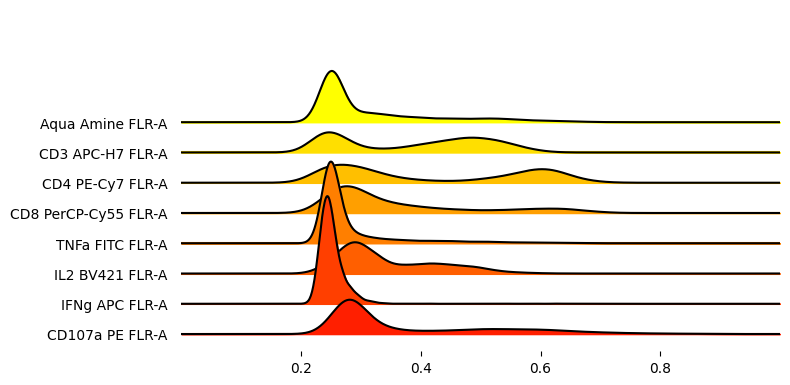

In [37]:
_ = joypy.joyplot(
    adata.to_df().sample(10_000),
    figsize=(8,4),
    column = markers,
    x_range=[0, 1],
    colormap=plt.cm.autumn_r, 
    overlap=1.5
)

In [38]:
# just to reference indices of gate names
pd.Series(adata.obsm['gate_membership'].columns)

0                                        root:Time
1                               root:Time:Singlets
2                       root:Time:Singlets:aAmine-
3                  root:Time:Singlets:aAmine-:CD3+
4             root:Time:Singlets:aAmine-:CD3+:CD4+
5     root:Time:Singlets:aAmine-:CD3+:CD4+:CD107a+
6       root:Time:Singlets:aAmine-:CD3+:CD4+:IFNg+
7        root:Time:Singlets:aAmine-:CD3+:CD4+:IL2+
8       root:Time:Singlets:aAmine-:CD3+:CD4+:TNFa+
9             root:Time:Singlets:aAmine-:CD3+:CD8+
10    root:Time:Singlets:aAmine-:CD3+:CD8+:CD107a+
11      root:Time:Singlets:aAmine-:CD3+:CD8+:IFNg+
12       root:Time:Singlets:aAmine-:CD3+:CD8+:IL2+
13      root:Time:Singlets:aAmine-:CD3+:CD8+:TNFa+
dtype: object

In [39]:
cd4_funcs = adata.obsm['gate_membership'].iloc[:, [5,6,7,8]]
cd4_bool = cd4_funcs.apply(lambda xs: np.sum([x*2**i for (i, x) in enumerate(xs)]), axis=1)
cd4_num_funcs = cd4_funcs.apply(lambda xs: xs.sum(), axis=1)

In [40]:
adata.obs['cd4'] = pd.Categorical(adata.obsm['gate_membership'].iloc[:, 4].astype(int).astype('str'))
adata.obs['cd4_bool'] = pd.Categorical(cd4_bool.astype('str').str.zfill(2))
adata.obs['cd4_funcs'] = pd.Categorical(cd4_num_funcs.astype('str'))

In [41]:
cd8_funcs = adata.obsm['gate_membership'].iloc[:, [10,11,12,13]]
cd8_bool = cd8_funcs.apply(lambda xs: np.sum([x*2**i for (i, x) in enumerate(xs)]), axis=1)
cd8_num_funcs = cd8_funcs.apply(lambda xs: xs.sum(), axis=1)

In [42]:
adata.obs['cd8'] = pd.Categorical(adata.obsm['gate_membership'].iloc[:, 9].astype('int').astype('str'))
adata.obs['cd8_bool'] = pd.Categorical(cd8_bool.astype('str').str.zfill(2))
adata.obs['cd8_funcs'] = pd.Categorical(cd8_num_funcs.astype('str'))

## Computing the neighborhood graph

To speed up UMAP calculations,
```
pip install pynndescent
```

In [43]:
# Subsample to speed things up
data = sc.pp.subsample(adata, n_obs=50_000, copy=True)

In [44]:
%%time
sc.pp.neighbors(data, n_neighbors=10, n_pcs=0)

CPU times: user 32.2 s, sys: 3.26 s, total: 35.5 s
Wall time: 26.3 s


In [45]:
%%time
sc.tl.leiden(data, resolution=0.1)

CPU times: user 5.43 s, sys: 78.8 ms, total: 5.5 s
Wall time: 5.51 s


In [46]:
%%time
sc.tl.paga(data)

CPU times: user 961 ms, sys: 40 ms, total: 1 s
Wall time: 1e+03 ms


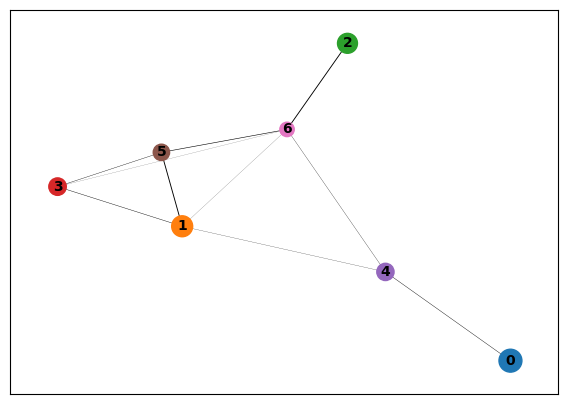

In [47]:
sc.pl.paga(data)

By quantifying the connectivity of partitions (groups, clusters) of the
single-cell graph, partition-based graph abstraction (PAGA) generates a much
simpler abstracted graph (*PAGA graph*) of partitions, in which edge weights
represent confidence in the presence of connections. By thresholding this
confidence in :func:`~scanpy.pl.paga`, a much simpler representation of the
manifold data is obtained, which is nonetheless faithful to the topology of
the manifold.

In [48]:
%%time
sc.tl.umap(data, init_pos='paga')

CPU times: user 33.5 s, sys: 111 ms, total: 33.6 s
Wall time: 33.5 s


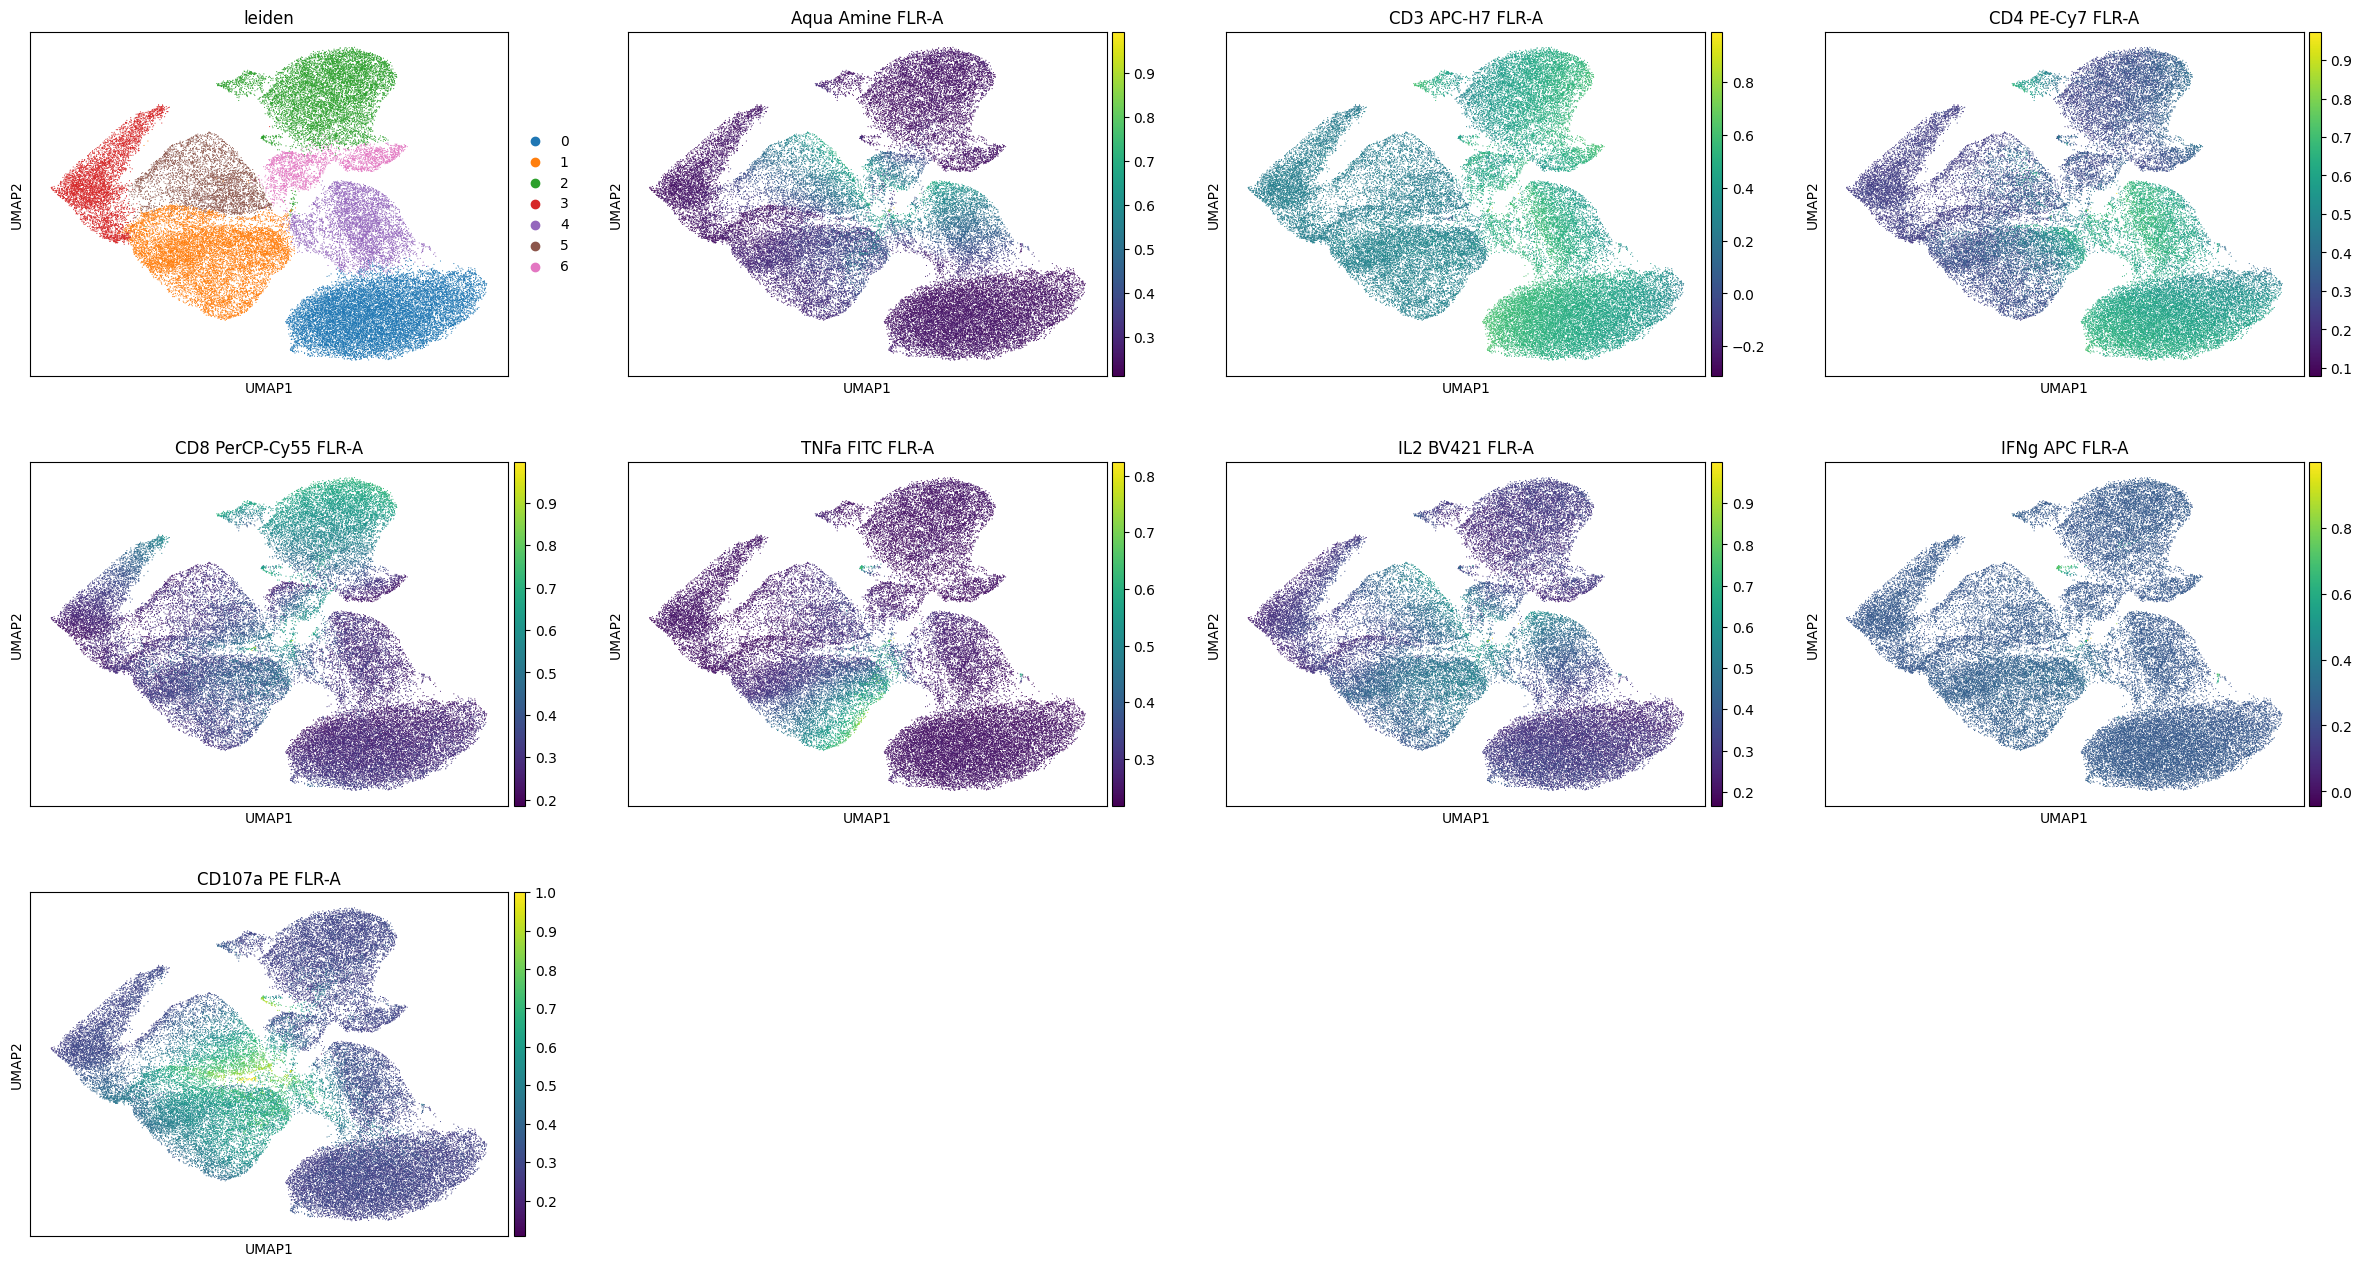

CPU times: user 3.51 s, sys: 164 ms, total: 3.67 s
Wall time: 3.45 s


In [49]:
%%time
sc.pl.umap(data, color=['leiden'] + markers)

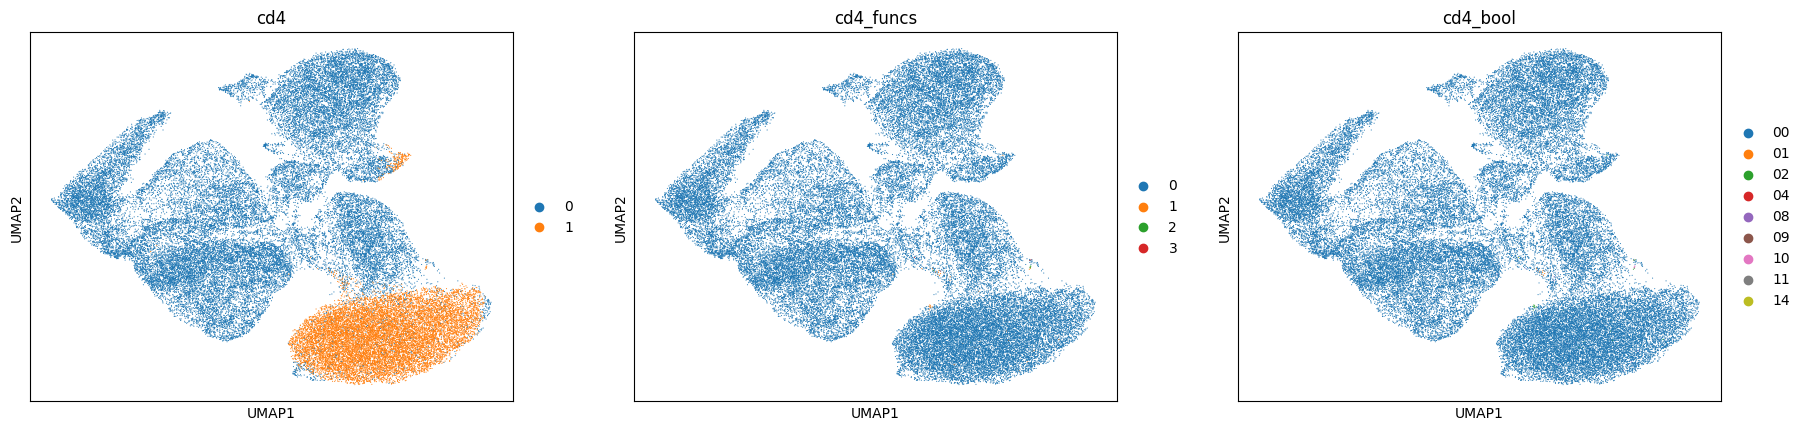

CPU times: user 1.48 s, sys: 188 ms, total: 1.67 s
Wall time: 1.44 s


In [50]:
%%time
sc.pl.umap(data, color=['cd4', 'cd4_funcs', 'cd4_bool'], cmap='turbo')

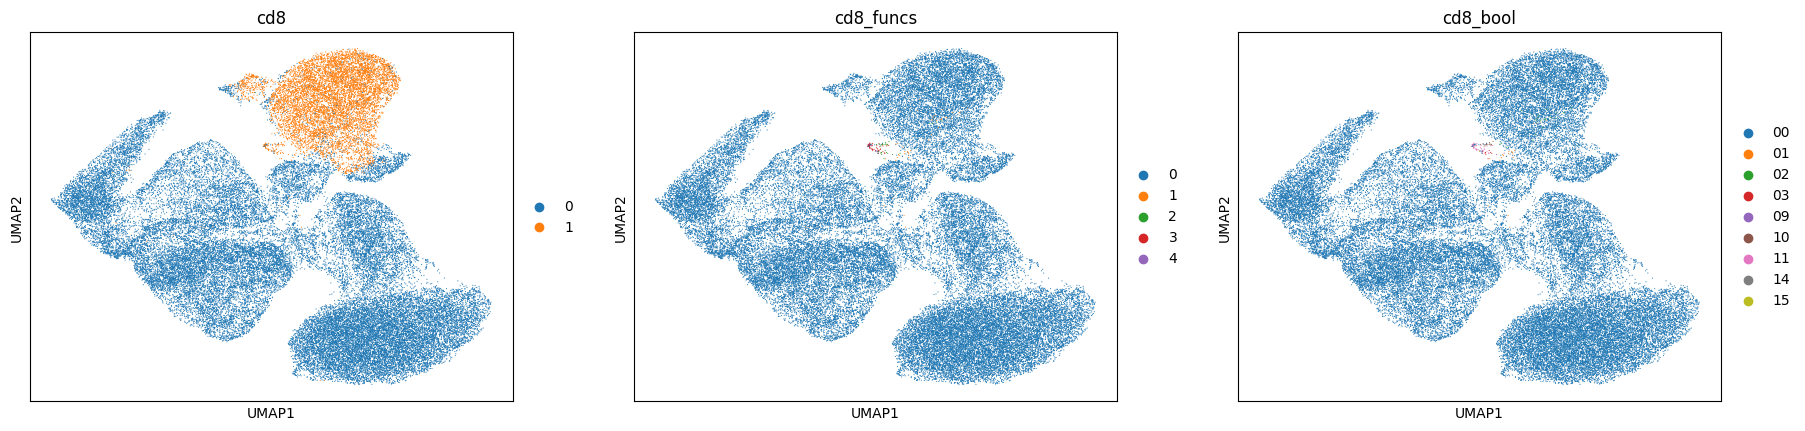

In [51]:
sc.pl.umap(data, color=['cd8', 'cd8_funcs', 'cd8_bool'], cmap='turbo')

In [52]:
sc.tl.embedding_density(
    data,
    groupby='cd4'
)

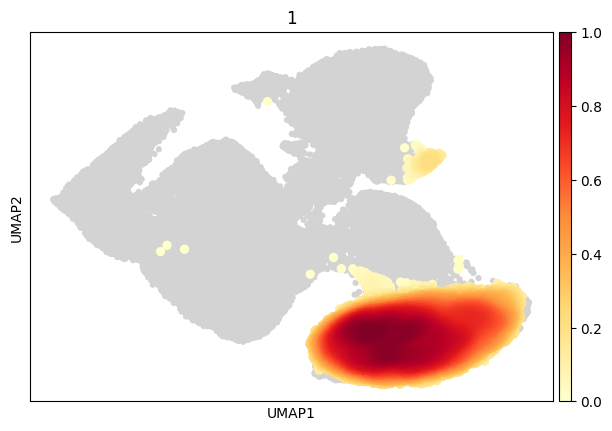

In [53]:
sc.pl.embedding_density(
    data,
    groupby='cd4',
    group='1'
)

In [54]:
sc.tl.embedding_density(
    data,
    groupby='cd4_funcs'
)

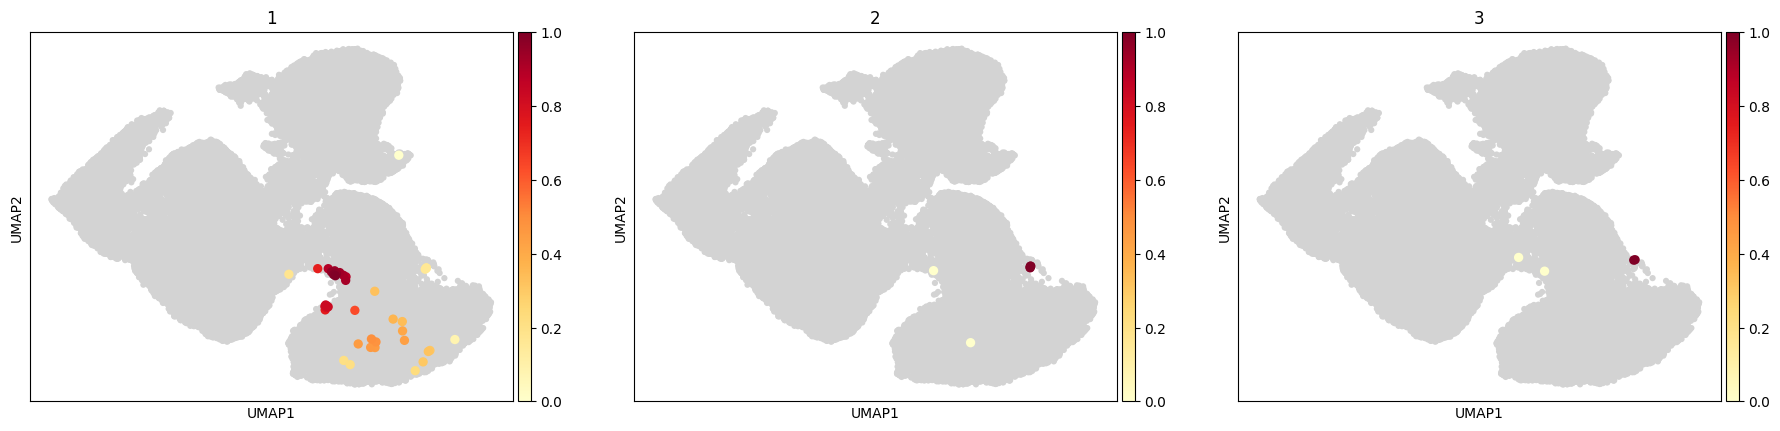

In [55]:
sc.pl.embedding_density(
    data,
    groupby='cd4_funcs',
    group=['1','2','3']
)

In [56]:
sc.tl.embedding_density(
    data,
    groupby='cd8'
)

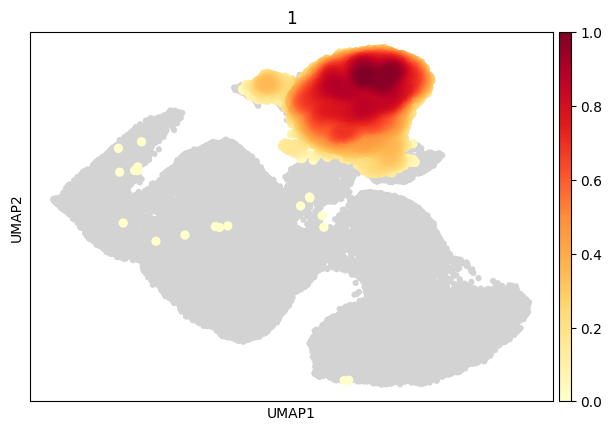

In [57]:
sc.pl.embedding_density(
    data,
    groupby='cd8',
    group='1'
)

In [58]:
sc.tl.embedding_density(
    data,
    groupby='cd8_funcs',
)

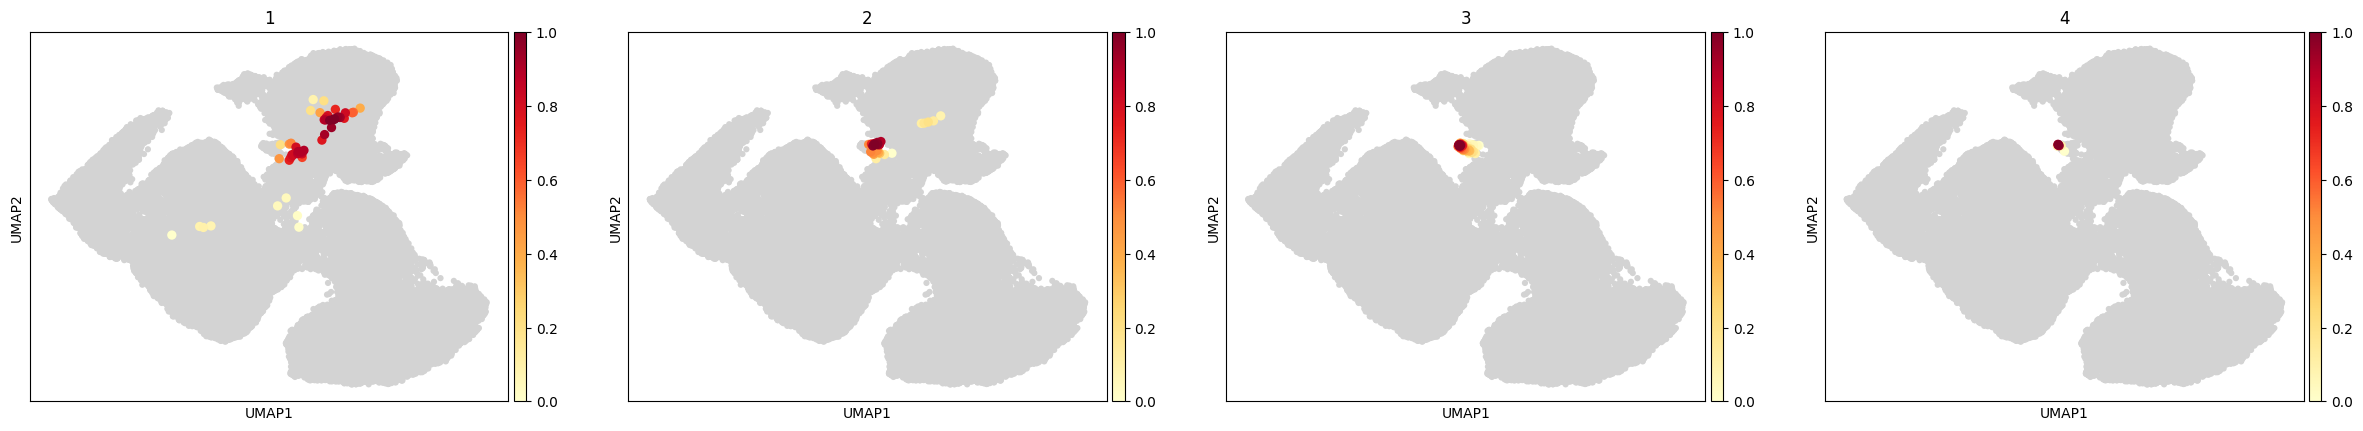

In [59]:
sc.pl.embedding_density(
    data,
    groupby='cd8_funcs',
    group=['1', '2', '3', '4'],

)

## Next example: Repeat but for CD8 T cells only

In [60]:
cd8_data = adata[adata.obsm['gate_membership']['root:Time:Singlets:aAmine-:CD3+:CD8+']]

In [61]:
cd8_data

View of AnnData object with n_obs × n_vars = 140676 × 8
    obs: 'sample_id', 'cd4', 'cd4_bool', 'cd4_funcs', 'cd8', 'cd8_bool', 'cd8_funcs'
    uns: 'gate_hierarchy', 'transforms'
    obsm: 'gate_membership'

In [62]:
sc.pp.neighbors(cd8_data, n_neighbors=30, n_pcs=0)

In [63]:
sc.tl.leiden(cd8_data, resolution=0.2)

In [64]:
sc.tl.paga(cd8_data)

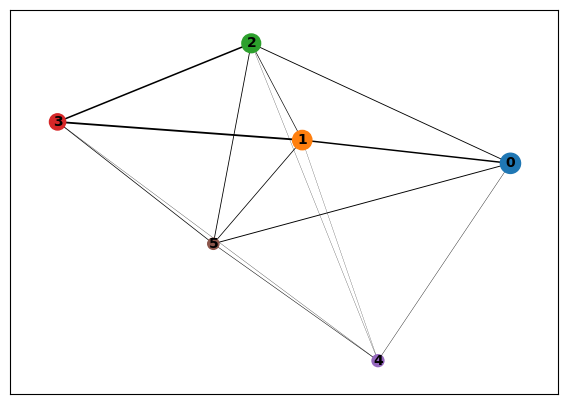

In [65]:
sc.pl.paga(cd8_data)

In [66]:
sc.tl.umap(cd8_data, init_pos='paga')

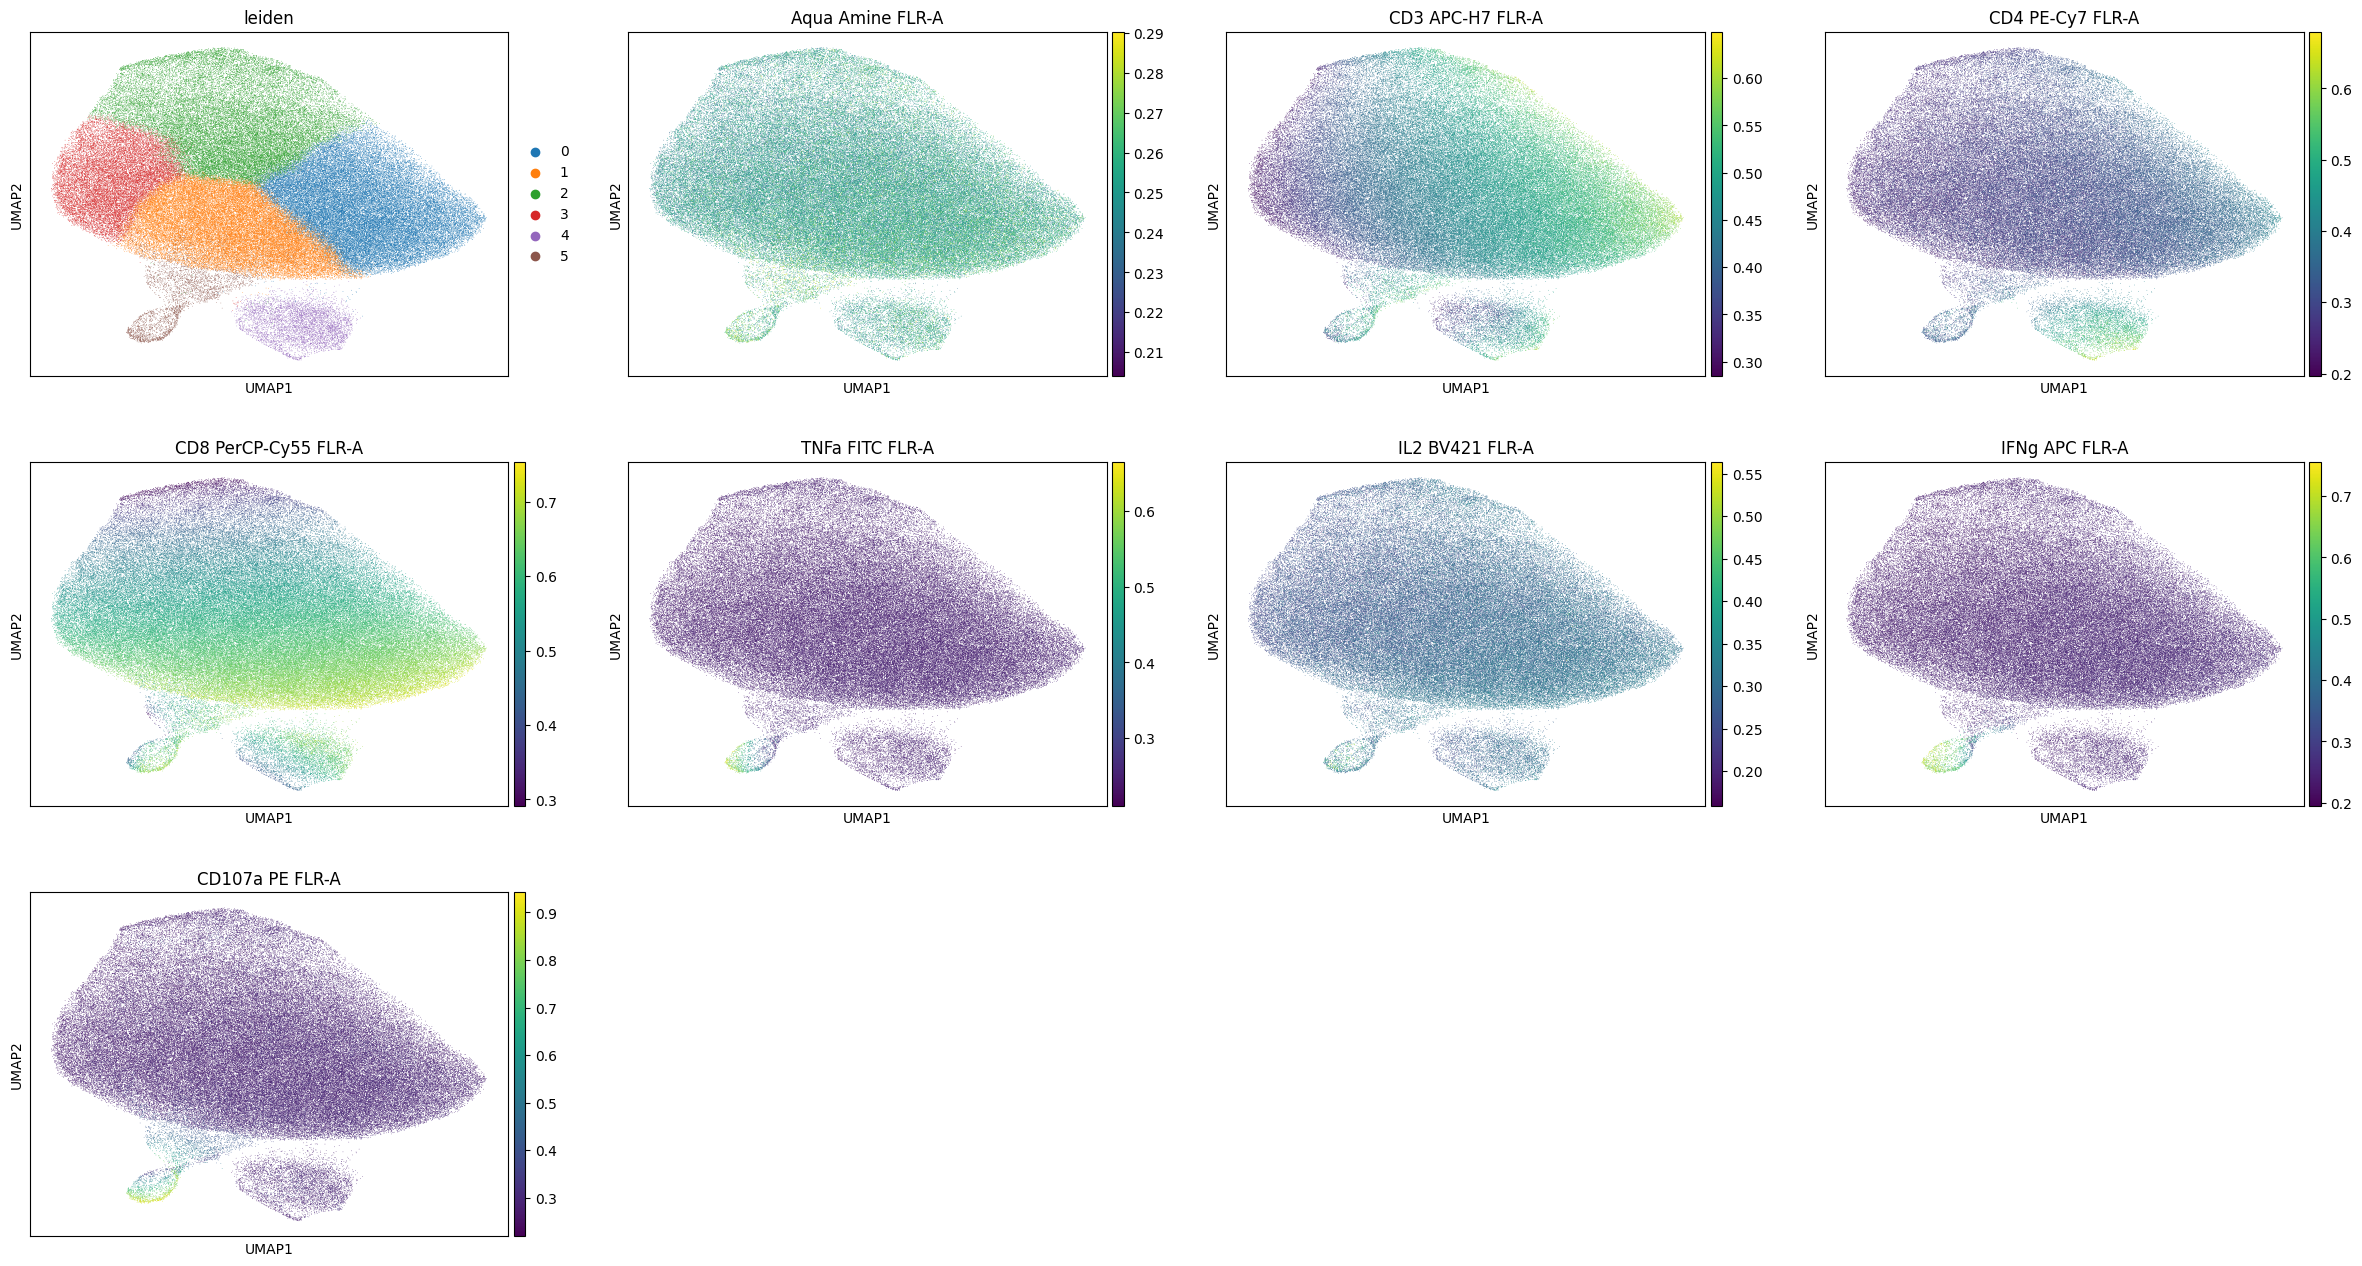

In [67]:
sc.pl.umap(
    cd8_data, 
    color=['leiden'] + markers,
)

In [68]:
sc.tl.embedding_density(
    cd8_data,
    groupby='leiden'
)

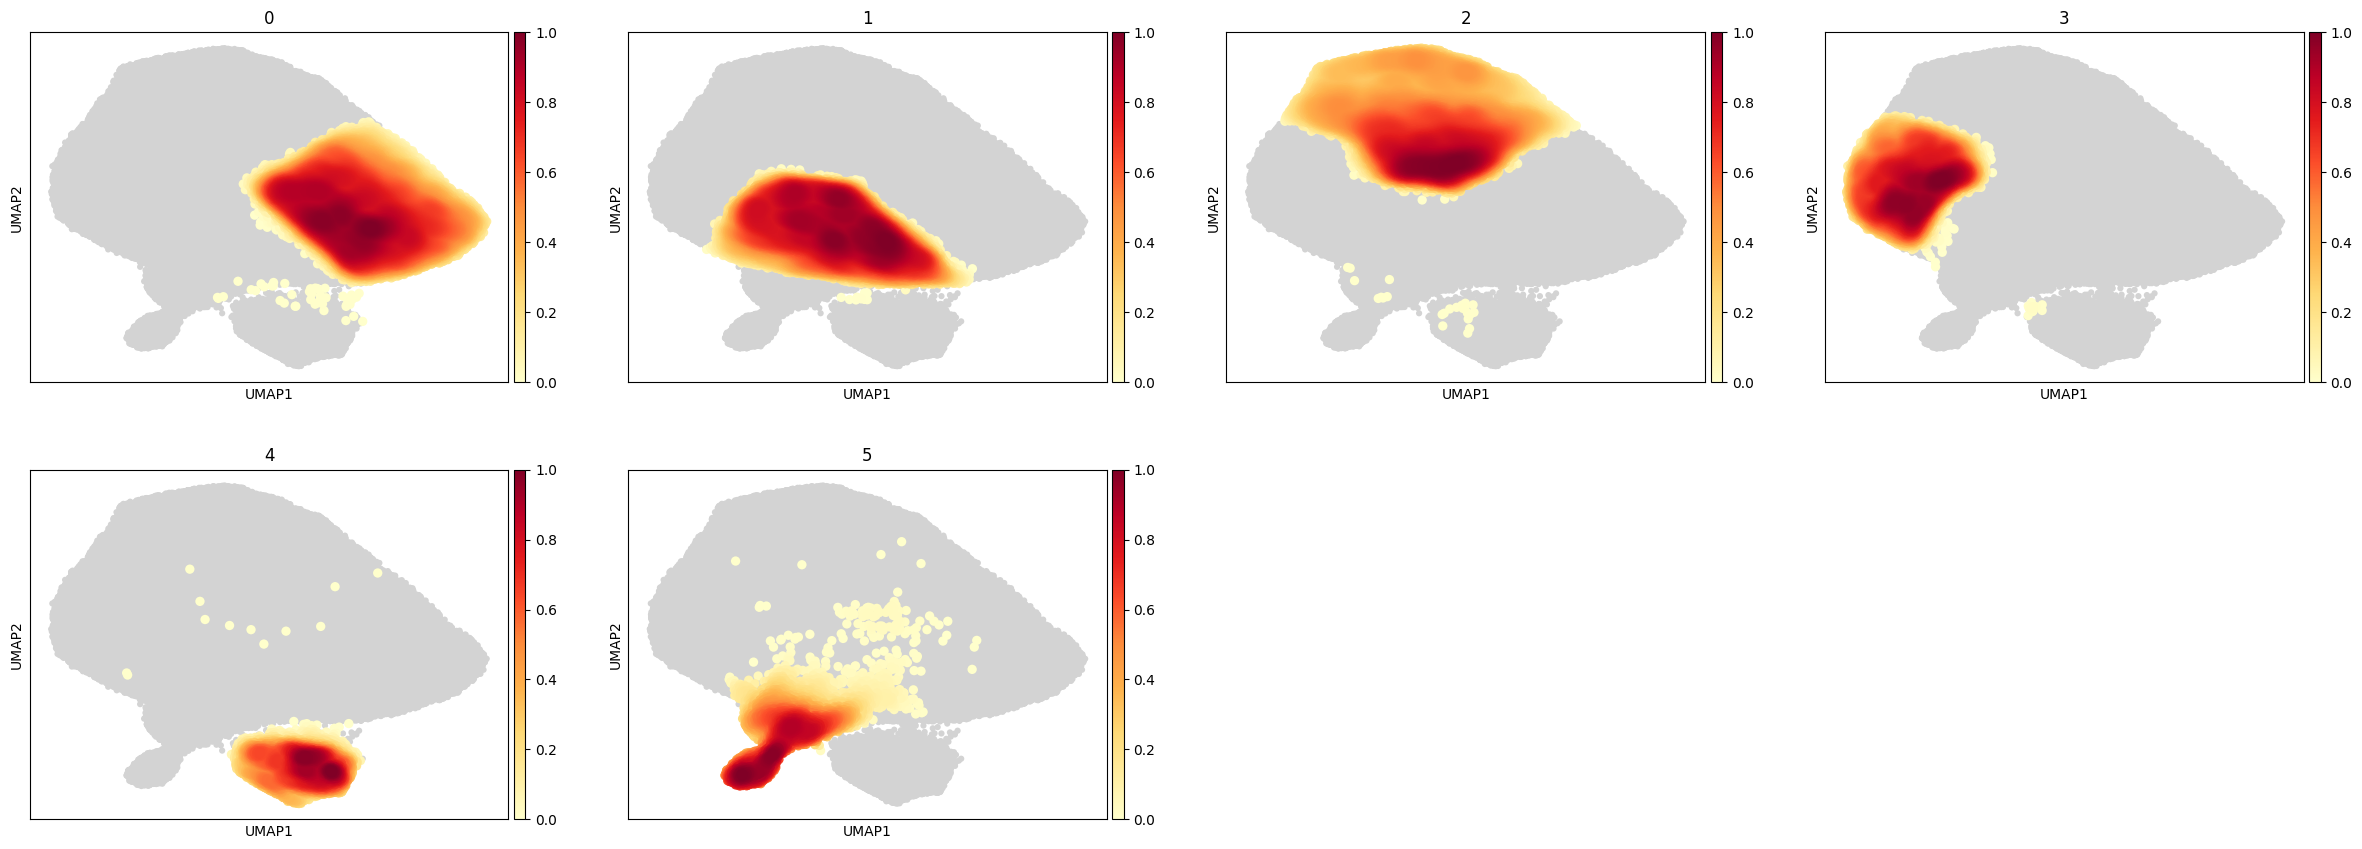

In [69]:
sc.pl.embedding_density(
    cd8_data,
    groupby='leiden',
)

## Finding markers

In [70]:
sc.tl.rank_genes_groups(
    cd8_data,
    groupby='leiden',
    method='wilcoxon'
)

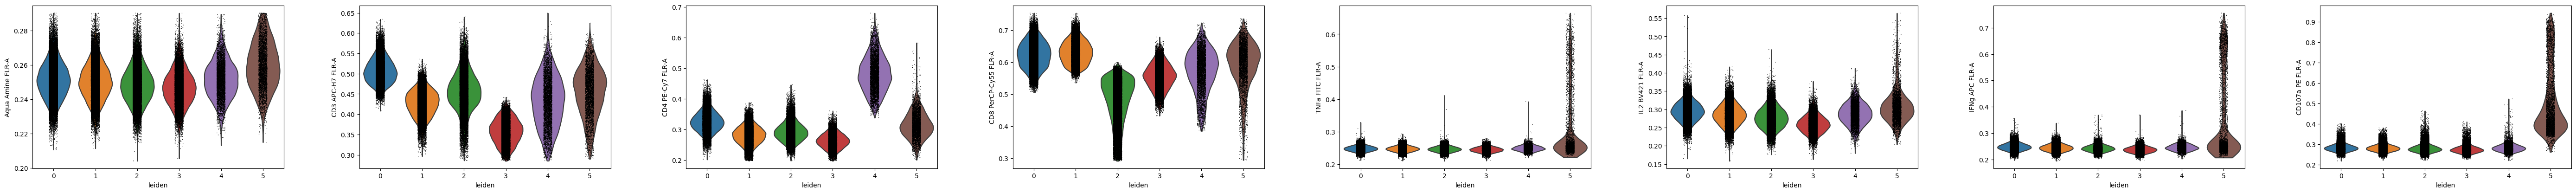

In [71]:
sc.pl.violin(cd8_data, markers, groupby='leiden')

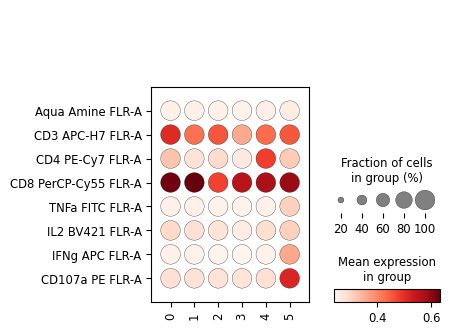

In [72]:
sc.pl.dotplot(cd8_data, markers, groupby='leiden', swap_axes=True)

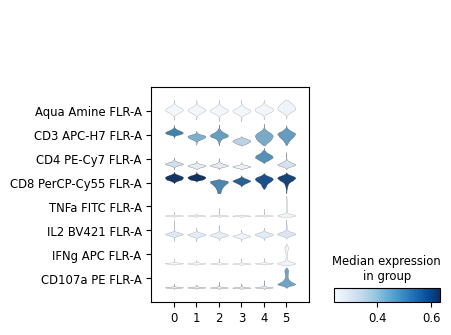

In [73]:
sc.pl.stacked_violin(cd8_data, markers, groupby='leiden', rotation=90, swap_axes=True)

In [74]:
sc.tl.dendrogram(cd8_data, groupby='leiden')

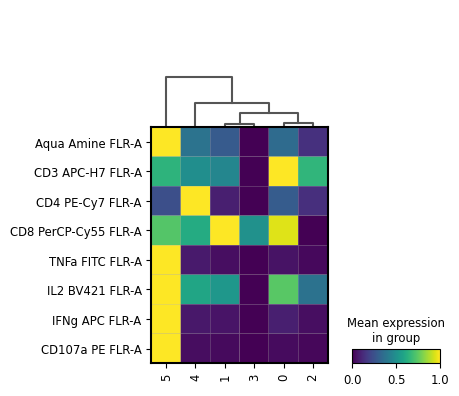

In [75]:
sc.pl.matrixplot(
    cd8_data,
    markers, 
    groupby='leiden',
    swap_axes=True,
    standard_scale='var', 
    log=False,
    dendrogram=True,
)

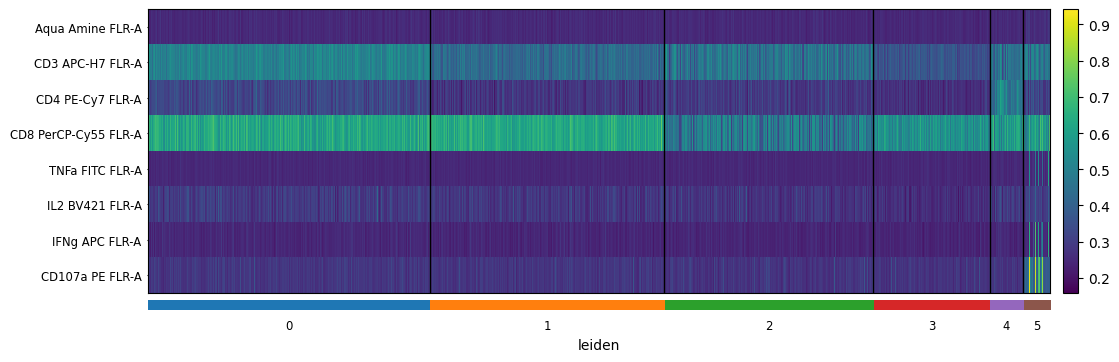

In [76]:
sc.pl.heatmap(
    cd8_data,
    markers,
    groupby='leiden',
    swap_axes=True,
    figsize=(12,4)
)

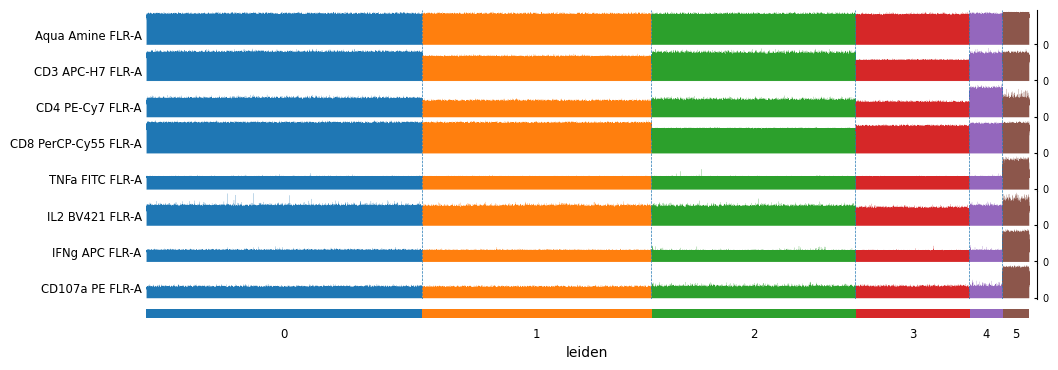

In [77]:
sc.pl.tracksplot(
    cd8_data,
    markers,
    groupby='leiden',
    swap_axes=True,
    figsize=(12,4)
)

In [78]:
cd8_data.layers['scaled'] = sc.pp.scale(cd8_data, copy=True).X

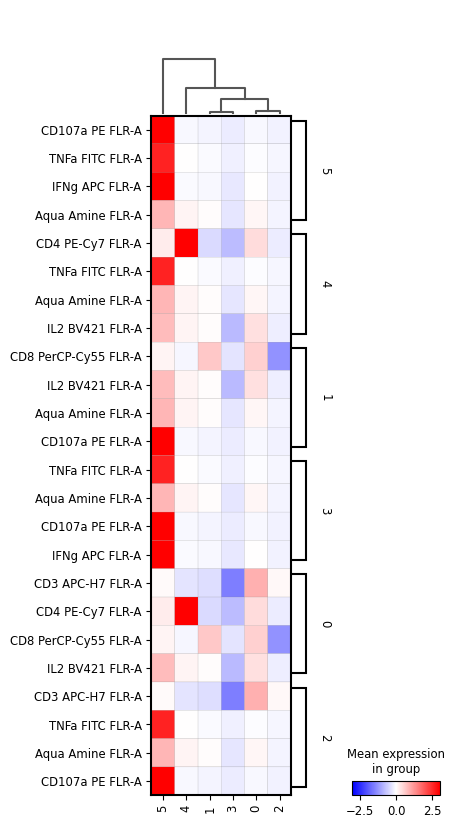

In [79]:
sc.pl.rank_genes_groups_matrixplot(
    cd8_data, 
    n_genes=4, 
    use_raw=False, 
    vmin=-3,
    vmax=3,
    cmap='bwr',
    layer='scaled',
    swap_axes=True
)

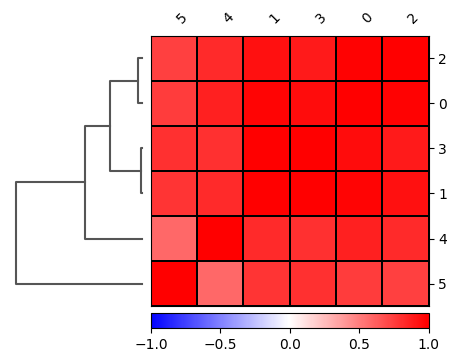

In [80]:
sc.pl.correlation_matrix(
    cd8_data,
    groupby='leiden',
)